# Comparing PyKAN, EfficientKAN and MLP

This notebook compares three neural network architectures:
1. PyKAN (original implementation)
2. EfficientKAN (optimized implementation) 
3. MLP (baseline)

We'll examine their performance on:
1. Basic interpolation (1D and 2D)
2. Implementation equivalence between PyKAN and EfficientKAN
3. Extrapolation capabilities

In [110]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Import implementations
from kan import KAN as PyKAN
from efficient_kan import KAN as EfficientKAN
from kan.MLP import MLP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

In [111]:
def train_model(model, dataset, steps=50):
    if isinstance(model, MLP):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        train_losses = []
        test_losses = []
        
        for i in tqdm(range(steps)):
            # Do multiple epochs per step
            for _ in range(100):  # Add epochs here
                optimizer.zero_grad()
                y_pred = model(dataset['train_input'])
                loss = nn.functional.mse_loss(y_pred, dataset['train_label'])
                loss.backward()
                optimizer.step()
            
            with torch.no_grad():
                train_loss = nn.functional.mse_loss(
                    model(dataset['train_input']), 
                    dataset['train_label']
                )
                test_loss = nn.functional.mse_loss(
                    model(dataset['test_input']), 
                    dataset['test_label']
                )
                train_losses.append(train_loss.item())
                test_losses.append(test_loss.item())
    else:
        # Original LBFGS code for other models
        optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
        model = model.to(device)
        
        train_losses = []
        test_losses = []
        
        for i in tqdm(range(steps)):
            def closure():
                optimizer.zero_grad()
                y_pred = model(dataset['train_input'])
                loss = nn.functional.mse_loss(y_pred, dataset['train_label'])
                loss.backward()
                return loss
            
            optimizer.step(closure)
            
            with torch.no_grad():
                train_loss = nn.functional.mse_loss(
                    model(dataset['train_input']), 
                    dataset['train_label']
                )
                test_loss = nn.functional.mse_loss(
                    model(dataset['test_input']), 
                    dataset['test_label']
                )
                train_losses.append(train_loss.item())
                test_losses.append(test_loss.item())
                
    return train_losses[-1], test_losses[-1]

def train_pykan(dataset, grid_size):
    model = PyKAN(width=[2,5,1], grid=grid_size, k=3, device=device)
    results = model.fit(dataset, opt="LBFGS", steps=50)
    return model, results['train_loss'][-1], results['test_loss'][-1]

## 1. Interpolation Tests

### 1.1 1D Sine Function

In [112]:
# Generate 1D data
def generate_1d_data(n_samples=1000):
    x = torch.linspace(-2, 2, n_samples).reshape(-1, 1)
    y = torch.sin(np.pi * x)
    
    train_idx = torch.randperm(n_samples)[:int(0.8*n_samples)]
    test_idx = torch.tensor(list(set(range(n_samples)) - set(train_idx.tolist())))
    
    return {
        'train_input': x[train_idx],
        'train_label': y[train_idx],
        'test_input': x[test_idx],
        'test_label': y[test_idx]
    }

dataset = generate_1d_data(1000)

# Train models
grid_size = 10
pykan_model = PyKAN([1,5,1], grid=grid_size, k=3, device=device)
effkan_model = EfficientKAN([1,5,1], grid_size=grid_size, spline_order=3)
mlp_model = MLP([1,5,1])

pykan_results = pykan_model.fit(dataset)
effkan_train_loss, effkan_test_loss = train_model(effkan_model, dataset)
mlp_train_loss, mlp_test_loss = train_model(mlp_model, dataset)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-04 | test_loss: 1.32e-04 | reg: 1.18e+01 | : 100%|█| 100/100 [00:07<00:00, 13.61


saving model version 0.1


100%|██████████| 50/50 [00:01<00:00, 38.47it/s]


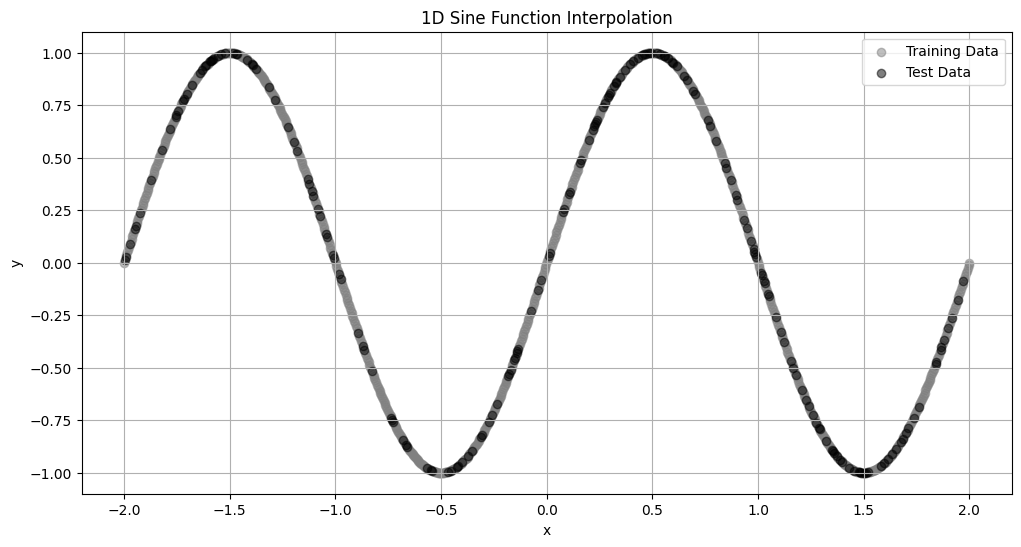

In [113]:
# 1.1 1D Sine Function Visualization
x_fine = torch.linspace(-2, 2, 200).reshape(-1, 1)
with torch.no_grad():
    pykan_preds = pykan_model(x_fine)
    effkan_preds = effkan_model(x_fine)
    mlp_preds = mlp_model(x_fine)
    true_vals = torch.sin(np.pi * x_fine)

plt.figure(figsize=(12, 6))
plt.scatter(dataset['train_input'], dataset['train_label'], 
           color='gray', alpha=0.5, label='Training Data')
plt.scatter(dataset['test_input'], dataset['test_label'], 
           color='black', alpha=0.5, label='Test Data')
plt.title('1D Sine Function Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

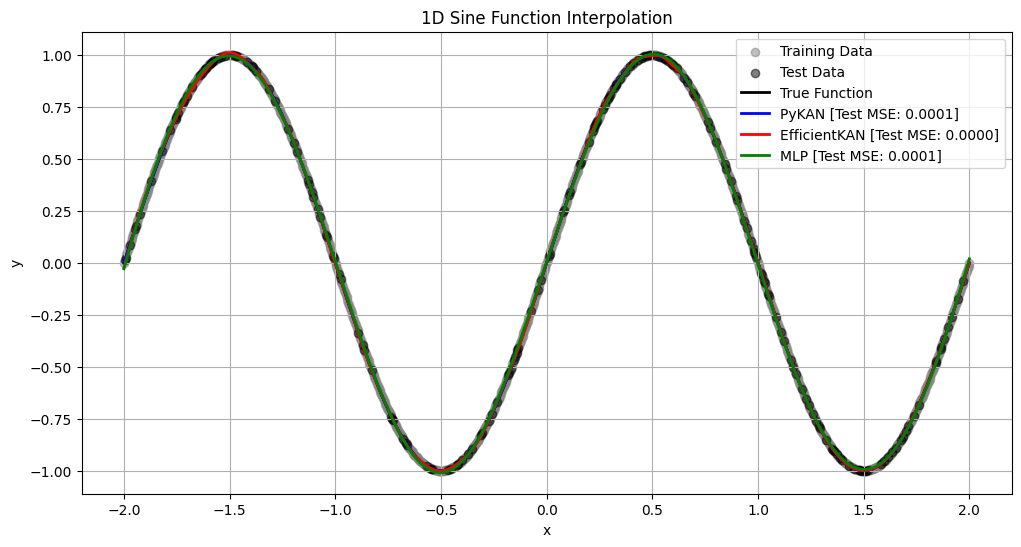

In [114]:
# 1.1 1D Sine Function Visualization
x_fine = torch.linspace(-2, 2, 200).reshape(-1, 1)
with torch.no_grad():
    pykan_preds = pykan_model(x_fine)
    effkan_preds = effkan_model(x_fine)
    mlp_preds = mlp_model(x_fine)
    true_vals = torch.sin(np.pi * x_fine)

plt.figure(figsize=(12, 6))
plt.scatter(dataset['train_input'], dataset['train_label'], 
           color='gray', alpha=0.5, label='Training Data')
plt.scatter(dataset['test_input'], dataset['test_label'], 
           color='black', alpha=0.5, label='Test Data')
plt.plot(x_fine, true_vals, 'k-', label='True Function', linewidth=2)
plt.plot(x_fine, pykan_preds, 'b-', 
        label=f'PyKAN [Test MSE: {pykan_results["test_loss"][-1]:.4f}]', linewidth=2)
plt.plot(x_fine, effkan_preds, 'r-', 
        label=f'EfficientKAN [Test MSE: {effkan_test_loss:.4f}]', linewidth=2)
plt.plot(x_fine, mlp_preds, 'g-',
        label=f'MLP [Test MSE: {mlp_test_loss:.4f}]', linewidth=2)
plt.title('1D Sine Function Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

### 1.2 2D Function: sin(πx₁) + cos(πx₂)

In [73]:
def generate_2d_data(n_samples=1000):
    x = torch.rand(n_samples, 2, device=device) * 4 - 2
    y = torch.sin(np.pi * x[:,[0]]) + torch.cos(np.pi * x[:,[1]])
    
    train_idx = torch.randperm(n_samples)[:int(0.8*n_samples)]
    test_idx = torch.tensor(list(set(range(n_samples)) - set(train_idx.tolist())))
    
    return {
        'train_input': x[train_idx],
        'train_label': y[train_idx],
        'test_input': x[test_idx],
        'test_label': y[test_idx]
    }

dataset = generate_2d_data(1000)

# Train models
grid_size = 10
pykan_model = PyKAN([2,5,1], grid=grid_size, k=3, device=device)
effkan_model = EfficientKAN([2,5,1], grid_size=grid_size, spline_order=3)
mlp_model = MLP([2,5,1])

pykan_results = pykan_model.fit(dataset)
effkan_train_loss, effkan_test_loss = train_model(effkan_model, dataset)
mlp_train_loss, mlp_test_loss = train_model(mlp_model, dataset)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.72e-03 | test_loss: 3.58e-03 | reg: 1.59e+01 | : 100%|█| 100/100 [00:07<00:00, 13.37


saving model version 0.1


100%|██████████| 50/50 [00:01<00:00, 36.20it/s]


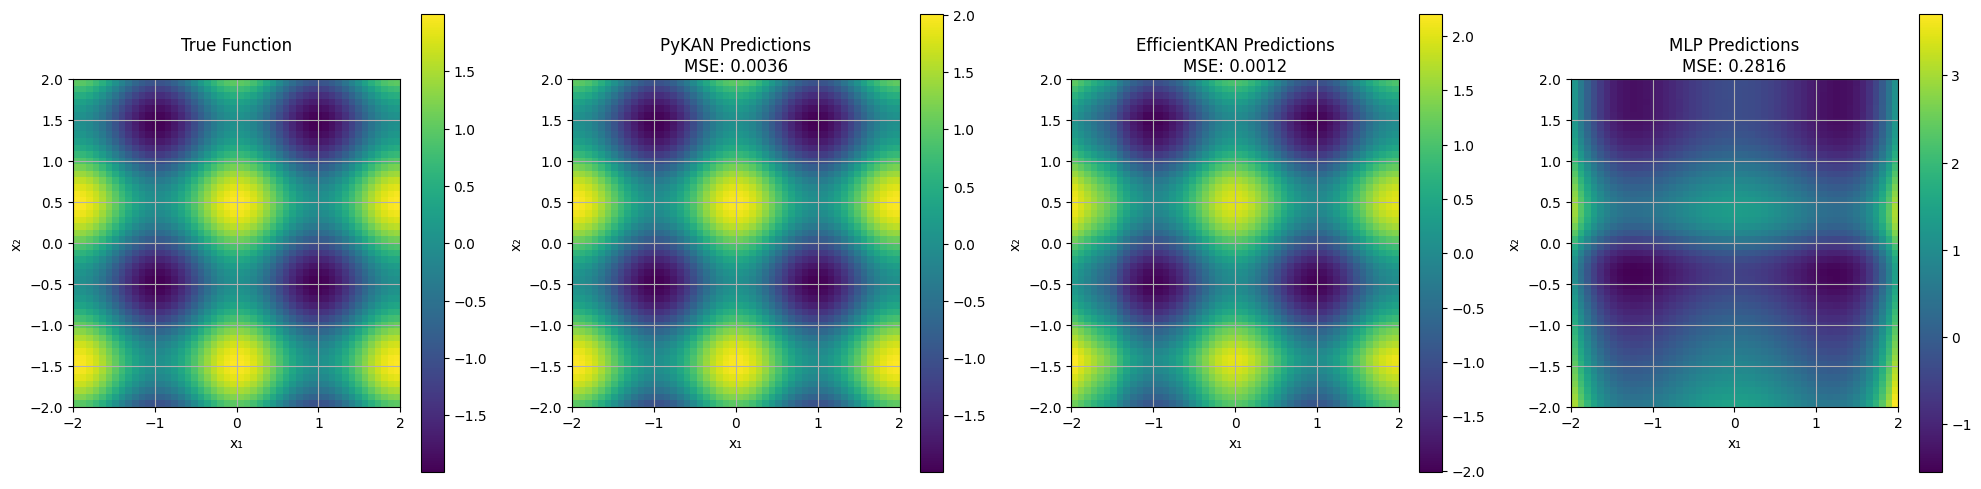

In [74]:
# 1.2 2D Function Visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Generate a fine grid of points
x1 = torch.linspace(-2, 2, 50)
x2 = torch.linspace(-2, 2, 50)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
test_inputs = torch.stack([X1.flatten(), X2.flatten()], dim=1)

# Get predictions
with torch.no_grad():
    pykan_preds = pykan_model(test_inputs).reshape(50, 50)
    effkan_preds = effkan_model(test_inputs).reshape(50, 50)
    mlp_preds = mlp_model(test_inputs).reshape(50, 50)
    true_vals = (torch.sin(np.pi * test_inputs[:,[0]]) + 
                 torch.cos(np.pi * test_inputs[:,[1]])).reshape(50, 50)

# Plot true function
im0 = axes[0].imshow(true_vals.numpy(), extent=[-2, 2, -2, 2], origin='lower')
axes[0].set_title('True Function\n')
plt.colorbar(im0, ax=axes[0])

# Plot PyKAN predictions
im1 = axes[1].imshow(pykan_preds.numpy(), extent=[-2, 2, -2, 2], origin='lower')
axes[1].set_title(f'PyKAN Predictions\nMSE: {pykan_results["test_loss"][-1]:.4f}')
plt.colorbar(im1, ax=axes[1])

# Plot EfficientKAN predictions
im2 = axes[2].imshow(effkan_preds.numpy(), extent=[-2, 2, -2, 2], origin='lower')
axes[2].set_title(f'EfficientKAN Predictions\nMSE: {effkan_test_loss:.4f}')
plt.colorbar(im2, ax=axes[2])

# Plot MLP predictions
im3 = axes[3].imshow(mlp_preds.numpy(), extent=[-2, 2, -2, 2], origin='lower')
axes[3].set_title(f'MLP Predictions\nMSE: {mlp_test_loss:.4f}')
plt.colorbar(im3, ax=axes[3])

# Add labels and grid to all subplots
for ax in axes:
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.grid(True)

plt.tight_layout()
plt.show()

## 2. Implementation Equivalence Study

Compare loss curves and prediction correlation across grid sizes.

In [75]:
grid_sizes = [3, 5, 10, 20, 50]
results = []

for grid in grid_sizes:
    print(f"\nTraining with grid size {grid}")
    
    dataset = generate_2d_data(1000)
    
    # Train all three models
    pykan_model, pt_loss, pv_loss = train_pykan(dataset, grid)
    effkan_model = EfficientKAN([2,5,1], grid_size=grid, spline_order=3)
    mlp_model = MLP([2,5,1])
    
    et_loss, ev_loss = train_model(effkan_model, dataset)
    mt_loss, mv_loss = train_model(mlp_model, dataset)
    
    results.append({
        'grid': grid,
        'params': grid * (2*5 + 5*1),
        'pykan': (pt_loss, pv_loss),
        'effkan': (et_loss, ev_loss),
        'mlp': (mt_loss, mv_loss)
    })


Training with grid size 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.39e-02 | test_loss: 2.59e-02 | reg: 1.35e+01 | : 100%|█| 50/50 [00:03<00:00, 14.17it


saving model version 0.1


100%|██████████| 50/50 [00:01<00:00, 33.12it/s]



Training with grid size 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.37e-03 | test_loss: 7.40e-03 | reg: 1.52e+01 | : 100%|█| 50/50 [00:03<00:00, 13.80it


saving model version 0.1


100%|██████████| 50/50 [00:01<00:00, 32.37it/s]



Training with grid size 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.11e-03 | test_loss: 3.94e-03 | reg: 1.36e+01 | : 100%|█| 50/50 [00:03<00:00, 13.65it


saving model version 0.1


100%|██████████| 50/50 [00:01<00:00, 32.73it/s]



Training with grid size 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-03 | test_loss: 1.96e-03 | reg: 1.36e+01 | : 100%|█| 50/50 [00:03<00:00, 12.55it


saving model version 0.1


100%|██████████| 50/50 [00:01<00:00, 34.10it/s]



Training with grid size 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.94e-03 | test_loss: 8.82e-03 | reg: 1.32e+01 | : 100%|█| 50/50 [00:05<00:00,  9.77it


saving model version 0.1


100%|██████████| 50/50 [00:01<00:00, 34.12it/s]


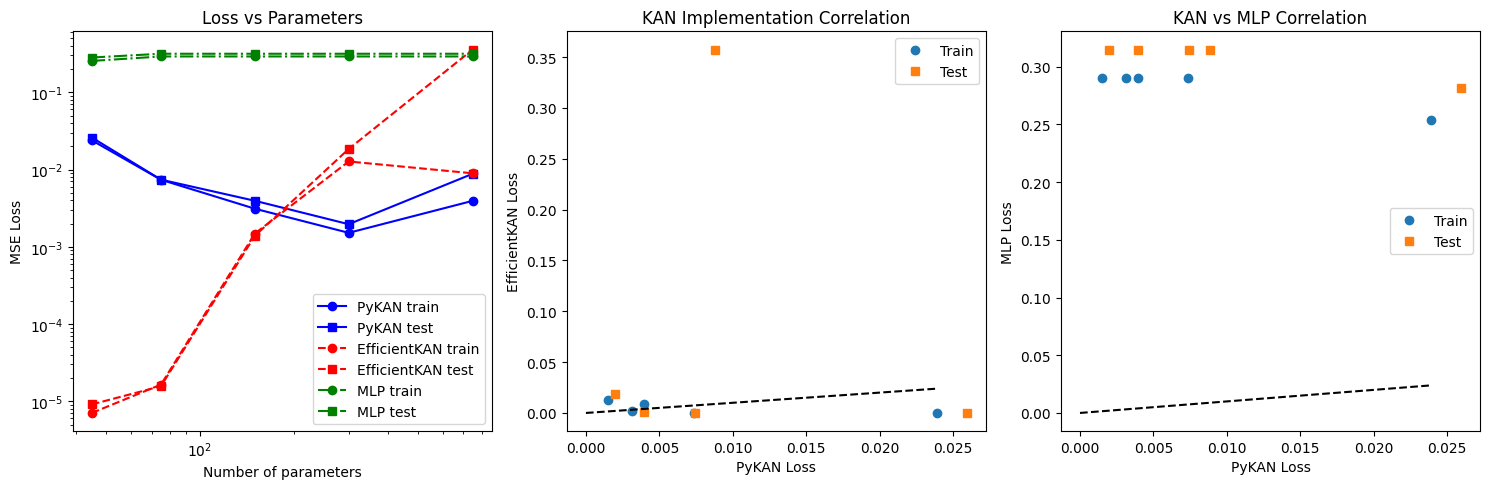

In [76]:
# 2. Implementation Equivalence Study Visualization
plt.figure(figsize=(15, 5))

# Extract data for plotting
n_params = [r['params'] for r in results]
pykan_train = [r['pykan'][0] for r in results]
pykan_test = [r['pykan'][1] for r in results]
effkan_train = [r['effkan'][0] for r in results]
effkan_test = [r['effkan'][1] for r in results]
mlp_train = [r['mlp'][0] for r in results]
mlp_test = [r['mlp'][1] for r in results]

# Loss vs Parameters plot
plt.subplot(131)
plt.plot(n_params, pykan_train, 'bo-', label='PyKAN train')
plt.plot(n_params, pykan_test, 'bs-', label='PyKAN test')
plt.plot(n_params, effkan_train, 'ro--', label='EfficientKAN train')
plt.plot(n_params, effkan_test, 'rs--', label='EfficientKAN test')
plt.plot(n_params, mlp_train, 'go-.', label='MLP train')
plt.plot(n_params, mlp_test, 'gs-.', label='MLP test')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of parameters')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Loss vs Parameters')

# PyKAN vs EfficientKAN correlation
plt.subplot(132)
plt.plot(pykan_train, effkan_train, 'o', label='Train')
plt.plot(pykan_test, effkan_test, 's', label='Test')
plt.plot([0, max(pykan_train)], [0, max(pykan_train)], 'k--')
plt.xlabel('PyKAN Loss')
plt.ylabel('EfficientKAN Loss')
plt.legend()
plt.title('KAN Implementation Correlation')

# PyKAN vs MLP correlation
plt.subplot(133)
plt.plot(pykan_train, mlp_train, 'o', label='Train')
plt.plot(pykan_test, mlp_test, 's', label='Test')
plt.plot([0, max(pykan_train)], [0, max(pykan_train)], 'k--')
plt.xlabel('PyKAN Loss')
plt.ylabel('MLP Loss')
plt.legend()
plt.title('KAN vs MLP Correlation')

plt.tight_layout()
plt.show()

## 3. Extrapolation Test

Train on [-2,1] and test on [1,2] to evaluate extrapolation capabilities.

In [79]:
def generate_extrapolation_data(n_train=800, n_test=200):
    x_train = torch.linspace(-2, 1, n_train).reshape(-1, 1)
    y_train = torch.sin(np.pi * x_train)
    
    x_test = torch.linspace(1, 2, n_test).reshape(-1, 1)
    y_test = torch.sin(np.pi * x_test)
    
    return {
        'train_input': x_train,
        'train_label': y_train,
        'test_input': x_test,
        'test_label': y_test
    }

dataset = generate_extrapolation_data()

# Fix: Change input dimension to 1
grid_size = 20
pykan_model = PyKAN([1,5,1], grid=grid_size, k=3, device=device)
effkan_model = EfficientKAN([1,5,1], grid_size=grid_size, spline_order=3)
mlp_model = MLP([1,5,1])

pykan_results = pykan_model.fit(dataset)
effkan_train_loss, effkan_test_loss = train_model(effkan_model, dataset)
mlp_train_loss, mlp_test_loss = train_model(mlp_model, dataset)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-03 | test_loss: 1.23e+00 | reg: 1.24e+01 | : 100%|█| 100/100 [00:06<00:00, 14.98


saving model version 0.1


100%|██████████| 50/50 [00:01<00:00, 38.81it/s]


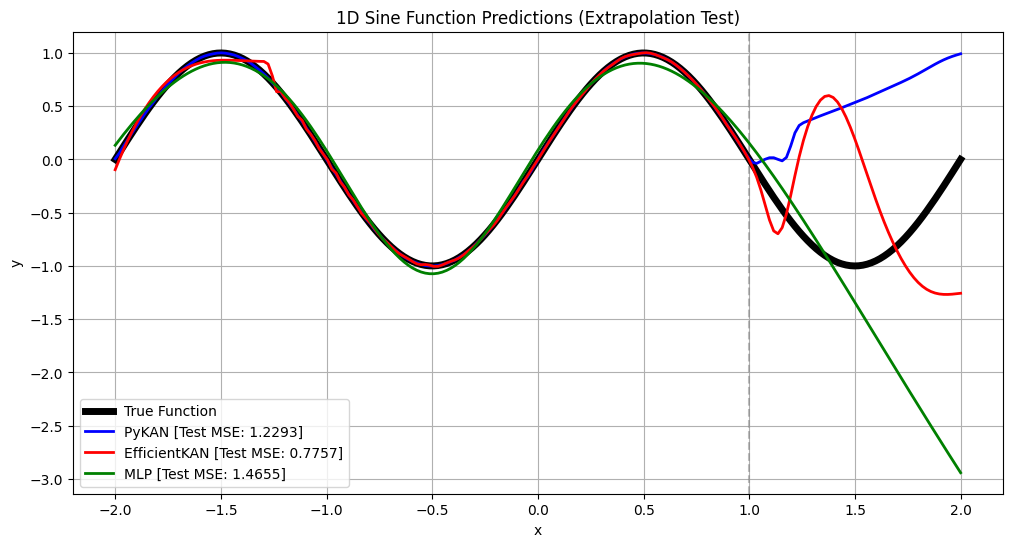

In [97]:
# 3. Extrapolation Test Visualization
x_fine = torch.linspace(-2, 2, 200).reshape(-1, 1)
with torch.no_grad():
    pykan_preds = pykan_model(x_fine)
    effkan_preds = effkan_model(x_fine)
    mlp_preds = mlp_model(x_fine)
    true_vals = torch.sin(np.pi * x_fine)

plt.figure(figsize=(12, 6))
plt.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
plt.plot(x_fine, true_vals, 'k-', label='True Function', linewidth=5)
plt.plot(x_fine, pykan_preds, 'b-', 
        label=f'PyKAN [Test MSE: {pykan_results["test_loss"][-1]:.4f}]', linewidth=2)
plt.plot(x_fine, effkan_preds, 'r-', 
        label=f'EfficientKAN [Test MSE: {effkan_test_loss:.4f}]', linewidth=2)
plt.plot(x_fine, mlp_preds, 'g-',
        label=f'MLP [Test MSE: {mlp_test_loss:.4f}]', linewidth=2)
plt.title('1D Sine Function Predictions (Extrapolation Test)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()